In [1]:
import os, sys, json, pickle
sys.path.insert(0, '/home/niell_lab/Documents/GitHub/FreelyMovingEphys/')
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import linregress
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import KernelDensity
from src.utils.path import list_subdirs, find
# from projects.ephys.addtl_headfixed import AddtlHF
from src.utils.auxiliary import flatten_series
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.signal import find_peaks

In [2]:
plasma_map = plt.cm.plasma(np.linspace(0,1,15))
cat_cmap = {
    'movement': plasma_map[12,:],
    'early': plasma_map[10,:],
    'late': plasma_map[8,:],
    'biphasic': plasma_map[5,:],
    'negative': plasma_map[2,:],
    'unresponsive': 'dimgrey'
}
colors = {
    'gaze': 'firebrick',
    'comp': 'mediumblue',
    'rc': 'indigo'
}

# Set paths

In [ ]:
probe = 'DB_P128-D'
new_dir = '/home/niell_lab/Data/freely_moving_ephys/ephys_recordings/032122/J599LT' # new animal directory
existing_pickle = '/home/niell_lab/Data/freely_moving_ephys/batch_files/051322/ltdk_051322.pickle'

# Create session dataframe

In [ ]:
subdirs = list_subdirs(new_dir, givepath=True)
usable_recordings = ['fm1','fm1_dark','fm_dark','hf1_wn','hf2_sparsenoiseflash','hf3_gratings','hf4_revchecker']
subdirs = [p for p in subdirs if any(s in p for s in usable_recordings)]
print(subdirs)

In [ ]:
df = pd.DataFrame([])
for path in subdirs:
    ephys_path = find('*_ephys_props.h5',path)[0]
    print(ephys_path)
    rec_data = pd.read_hdf(ephys_path)
    rec_type = '_'.join(([col for col in rec_data.columns.values if 'contrast_tuning_bins' in col][0]).split('_')[:-3])
    rec_data = rec_data.rename(columns={'spikeT':rec_type+'_spikeT',
                                        'spikeTraw':rec_type+'_spikeTraw',
                                        'rate':rec_type+'_rate',
                                        'n_spikes':rec_type+'_n_spikes'})
    # get column names
    column_names = list(df.columns.values) + list(rec_data.columns.values)
    # new columns for same unit within a session
    df = pd.concat([df, rec_data],axis=1,ignore_index=True)
    # add the list of column names from all sessions plus the current recording
    df.columns = column_names
    # remove duplicate columns (i.e. shared metadata)
    df = df.loc[:,~df.columns.duplicated()]

In [ ]:
ellipse_json_path = find('*fm_eyecameracalc_props.json', new_dir)[0]
print(ellipse_json_path)
with open(ellipse_json_path) as f:
    ellipse_fit_params = json.load(f)
df['best_ellipse_fit_m'] = ellipse_fit_params['regression_m']
df['best_ellipse_fit_r'] = ellipse_fit_params['regression_r']

df['original_session_path'] = new_dir
df['probe_name'] = probe

df['index'] = df.index.values
df.reset_index(inplace=True)

# Fix gratings spatial frequencies

In [ ]:
for ind, row in df.iterrows():
    tuning = row['Gt_ori_tuning_tf'].copy().astype(float)
    new_tuning = np.roll(tuning, 1, axis=1)
    df.at[ind, 'Gt_ori_tuning_tf'] = new_tuning.astype(object)

# Recalculate eye movement PSTH

In [ ]:
def calc_kde_sdf(spikeT, eventT, bandwidth=10, resample_size=1, edgedrop=15, win=1000):
    """
    bandwidth (in msec)
    resample_size (msec)
    edgedrop (msec to drop at the start and end of the window so eliminate artifacts of filtering)
    win = 1000msec before and after
    """
    # some conversions
    bandwidth = bandwidth/1000 # msec to sec
    resample_size = resample_size/1000 # msec to sec
    win = win/1000 # msec to sec
    edgedrop = edgedrop/1000
    edgedrop_ind = int(edgedrop/resample_size)

    # setup time bins
    bins = np.arange(-win-edgedrop, win+edgedrop+resample_size, resample_size)

    # get timestamp of spikes relative to events in eventT
    sps = []
    for i, t in enumerate(eventT):
        sp = spikeT-t
        sp = sp[(sp <= (win+edgedrop)) & (sp >= (-win-edgedrop))] # only keep spikes in this window
        sps.extend(sp)
    sps = np.array(sps) # all values in here are between -1 and 1

    # kernel density estimation
    kernel = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(sps[:,np.newaxis])
    density = kernel.score_samples(bins[:,np.newaxis])
    sdf = np.exp(density)*(np.size(sps)/np.size(eventT)) # convert back to spike rate
    sdf = sdf[edgedrop_ind:-edgedrop_ind]

    return sdf

def apply_win_to_comp_sacc(comp, gazeshift, win=0.25):
    bad_comp = np.array([c for c in comp for g in gazeshift if ((g>(c-win)) & (g<(c+win)))])
    comp_times = np.delete(comp, np.isin(comp, bad_comp))
    return comp_times

In [ ]:
stims = ['FmLt', 'FmDk'] # 'FmDk'

saccthresh = { # deg/sec
    'head_moved': 60,
    'gaze_stationary': 120,
    'gaze_moved': 240
}

for stim in stims:
    print('calculating movement times')
    dHead = df[stim+'_dHead'].iloc[0]
    dGaze = df[stim+'_dGaze'].iloc[0]
    eyeT = df[stim+'_eyeT'].iloc[0][:-1]

    gazeL = eyeT[(dHead > saccthresh['head_moved']) & (dGaze > saccthresh['gaze_moved'])]
    gazeR = eyeT[(dHead < -saccthresh['head_moved']) & (dGaze < -saccthresh['gaze_moved'])]

    compL = eyeT[(dHead > saccthresh['head_moved']) & (dGaze < saccthresh['gaze_stationary']) & (dGaze > -saccthresh['gaze_stationary'])]
    compR = eyeT[(dHead < -saccthresh['head_moved']) & (dGaze > -saccthresh['gaze_stationary']) & (dGaze < saccthresh['gaze_stationary'])]

    compL = apply_win_to_comp_sacc(compL, gazeL)
    compR = apply_win_to_comp_sacc(compR, gazeR)

    # SDFs
    for ind in tqdm(df.index.values):
        spikeT = df.loc[ind,stim+'_spikeT']

        movements = [gazeL, gazeR, compL, compR]
        movkeys = [stim+'_gazeshift_left_saccPSTH_dHead',
                stim+'_gazeshift_right_saccPSTH_dHead',
                stim+'_comp_left_saccPSTH_dHead',
                stim+'_comp_right_saccPSTH_dHead']
        timekeys = [stim+'_gazeshift_left_saccTimes_dHead',
                stim+'_gazeshift_right_saccTimes_dHead',
                stim+'_comp_left_saccTimes_dHead',
                stim+'_comp_right_saccTimes_dHead']
        for x in range(4):
            movkey = movkeys[x]
            timekey = timekeys[x]
            eventT = movements[x]

            # save the spike density function
            sdf = calc_kde_sdf(spikeT, eventT)
            df.at[ind, movkey] = sdf.astype(object)

            # save the saccade times
            df.at[ind, timekey] = eventT.astype(object)

In [ ]:
df.to_hdf('/home/niell_lab/Desktop/temp_df_032122.h5', 'w')

In [ ]:
df = pd.read_hdf('/home/niell_lab/Desktop/temp_df_032122.h5')

# Head-fixed checkerboard and sparse noise

## Calculate

In [ ]:
ahf = AddtlHF(new_dir)
print('Sparse noise')
ahf.calc_Sn_psth()
print('Reversing checkerboard')
ahf.calc_Rc_psth()
ahf.save()

In [ ]:
df = pd.read_hdf('/home/niell_lab/Desktop/temp_df_032022.h5')

## Add into dataset

In [ ]:
# set up and create empty columns
dummy_psth = np.zeros([2001])*np.nan
psth_series = pd.Series([])
for i in range(len(df)):
    psth_series[i] = dummy_psth.astype(object)
for col in ['Rc_psth','Sn_on_all_psth','Sn_on_darkstim_psth','Sn_on_lightstim_psth',
            'Sn_on_background_psth','Sn_off_all_psth','Sn_off_darkstim_psth',
            'Sn_off_lightstim_psth','Sn_off_background_psth']:
    df[col] = psth_series.copy().astype(object)
dummy_vals = np.zeros([2])*np.nan
dummy_series = pd.Series([])
for i in range(len(df)):
    dummy_series[i] = dummy_vals.astype(object)
df['Wn_rf_on_cent'] = dummy_series.copy().astype(object)
df['Wn_rf_off_cent'] = dummy_series.copy().astype(object)

df['original_session_path']
psth_files = find('addtlhf_props2.npz', new_dir)[0]
print('reading '+psth_files)
psth_data = np.load(psth_files)
# reversing checkerboard
rc_psth = psth_data['rc'] # shape is [unit#, time]
# sparse noise
sn_on_psth = psth_data['sn_on'] # shape is [unit#, time, all/l2d/d2l/only_global]
sn_off_psth = psth_data['sn_off'] # shape is [unit#, time, all/l2d/d2l/only_global]
# receptive field centers
rf_xy = psth_data['rf'] # shape is [unit#, x/y]

# just the current session
for i, ind in enumerate(df.index.values):
    df.at[ind, 'has_hfpsth'] = True
    df.at[ind, 'Rc_psth'] = rc_psth[i,:]
    df.at[ind, 'Wn_rf_on_cent'] = rf_xy[i,:2]
    df.at[ind, 'Wn_rf_off_cent'] = rf_xy[i,2:]

    df.at[ind, 'Sn_on_all_psth'] = sn_on_psth[i,:,0]
    df.at[ind, 'Sn_on_darkstim_psth'] = sn_on_psth[i,:,1]
    df.at[ind, 'Sn_on_lightstim_psth'] = sn_on_psth[i,:,2]
    df.at[ind, 'Sn_on_background_psth'] = sn_on_psth[i,:,3]

    df.at[ind, 'Sn_off_all_psth'] = sn_off_psth[i,:,0]
    df.at[ind, 'Sn_off_darkstim_psth'] = sn_off_psth[i,:,1]
    df.at[ind, 'Sn_off_lightstim_psth'] = sn_off_psth[i,:,2]
    df.at[ind, 'Sn_off_background_psth'] = sn_off_psth[i,:,3]

In [ ]:
df.to_hdf('/home/niell_lab/Desktop/temp_df_032022_v2.h5', 'w')

# Add into shared dataset

In [ ]:
data = pd.read_pickle(existing_pickle)

In [ ]:
data1 = pd.concat([data, df], axis=0)

In [ ]:
data1.reset_index(inplace=True, drop=True)

In [ ]:
data1.to_pickle('/home/niell_lab/Data/freely_moving_ephys/batch_files/ltdk_051822.pickle')

# Redo summary analysis

In [3]:
data = pd.read_pickle('/home/niell_lab/Data/freely_moving_ephys/batch_files/061522/hffm_061522.pickle')

In [ ]:
data = pd.read_pickle('/home/niell_lab/Data/freely_moving_ephys/batch_files/061322/ltdk_061322.pickle')

## remove recordings

In [ ]:
data['session'].unique()

In [ ]:
data = data[data['session']!='032122_J599LT_control_Rig2']

In [ ]:
len(data.index.values)

## Putative cell type

In [ ]:
data['norm_waveform'] = data['waveform']
for ind, row in data.iterrows():
    if type(row['waveform']) == list:
        starting_val = np.mean(row['waveform'][:6])
        center_waveform = [i-starting_val for i in row['waveform']]
        norm_waveform = center_waveform / -np.min(center_waveform)
        data.at[ind, 'waveform_trough_width'] = len(norm_waveform[norm_waveform < -0.2])
        data.at[ind, 'AHP'] = norm_waveform[27]
        data.at[ind, 'waveform_peak'] = norm_waveform[18]
        data.at[ind, 'norm_waveform'] = norm_waveform

km_labels = KMeans(n_clusters=2).fit(list(data['norm_waveform'][data['waveform_peak'] < 0].to_numpy())).labels_
# make inhibitory is always group 0
# excitatory should always have a smaller mean waveform trough
# if it's larger, flip the kmeans labels
if np.mean(data['waveform_trough_width'][data['waveform_peak']<0][km_labels==0]) > np.mean(data['waveform_trough_width'][data['waveform_peak']<0][km_labels==1]):
    km_labels = [0 if i==1 else 1 for i in km_labels]

count = 0
for ind, row in data.iterrows():
    if row['waveform_peak'] < 0 and row['AHP'] < 0.7:
        data.at[ind, 'waveform_km_label'] = km_labels[count]
        count = count+1

# make new column of strings for excitatory vs inhibitory clusters
for ind, row in data.iterrows():
    if row['waveform_km_label'] == 0:
        data.at[ind, 'exc_or_inh'] = 'inh'
    elif row['waveform_km_label'] == 1:
        data.at[ind, 'exc_or_inh'] = 'exc'

## Eye/head movements

In [40]:
def z_score(A):
    return (np.max(np.abs(A))-np.mean(A)) / np.std(A)

def psth_modind(psth):
    # modulation in terms of spike rate
    psth = psth.astype(float)
    use = psth - np.mean(psth[0:800].copy())
    mod = np.max(np.abs(use[1000:1250]))
    return mod

def calc_latency(psth):
    # use norm PSTH
    ind = np.argmax(psth[1000:1250])+1000 # was 1000:1170
    peakT = psth_bins[ind]
    val = psth[ind]
    return peakT, val

def get_direction_pref(left, right):
    # use raw PSTH
    
    leftmod = psth_modind(left)
    rightmod = psth_modind(right)

    ind = np.argmax([leftmod, rightmod])
    
    pref = [left, right][ind]
    nonpref = [left, right][1-ind]
    
    prefname = ['left','right'][ind]
    nonprefname = ['left','right'][1-ind]
    
    return pref, nonpref, prefname, nonprefname

def calc_psth_DSI(pref, nonpref):
    # use pref
    
    prefmod = psth_modind(pref)
    nonprefmod = psth_modind(nonpref)
    
    mod = (prefmod - nonprefmod) / (prefmod + nonprefmod)
    
    return mod
    
def normalize_psth(psth, raw_pref=None, baseline_val=None):
    if raw_pref is None:
        raw_pref = psth.copy()
    if baseline_val is None:
        baseline_val = np.mean(psth[0:800].astype(float))
    norm_psth = (psth - baseline_val) / np.max(raw_pref[750:1250].astype(float)) # [1000:1250]
    return norm_psth

def normalize_gt_psth(psth, baseind=4, zeroind = 5):
    baseline_val = np.nanmedian(psth[:5])
    norm_psth = (psth - baseline_val) / np.nanmax(psth[5:14].astype(float))
    return norm_psth

def gt_modind(psth):
    psth = psth.astype(float)
    use = psth - np.mean(psth[1:5].copy())
    mod = np.max(np.abs(use[5:8]))
    return mod

### FmLt

In [41]:
for ind, row in data.iterrows():
    pref, nonpref, prefname, nonprefname = get_direction_pref(row['FmLt_gazeshift_left_saccPSTH_dHead1'], row['FmLt_gazeshift_right_saccPSTH_dHead1'])
    data.at[ind,'pref_gazeshift_direction'] = prefname
    data.at[ind,'nonpref_gazeshift_direction'] = nonprefname
    data.at[ind,'gazeshift_DSI'] = calc_psth_DSI(pref, nonpref)
    # norm gaze shifts
    data.at[ind, 'pref_gazeshift_psth'] = normalize_psth(pref).astype(object)
    data.at[ind, 'nonpref_gazeshift_psth'] = normalize_psth(nonpref, raw_pref=pref).astype(object)
    # raw gaze shifts and comp
    data.at[ind, 'pref_gazeshift_psth_raw'] = pref.copy().astype(object)
    data.at[ind, 'nonpref_gazeshift_psth_raw'] = nonpref.copy().astype(object)
    # compensatory
    data.at[ind, 'pref_comp_psth_raw'] = row['FmLt_comp_{}_saccPSTH_dHead1'.format(prefname)].copy().astype(object)
    data.at[ind, 'nonpref_comp_psth_raw'] = row['FmLt_comp_{}_saccPSTH_dHead1'.format(nonprefname)].copy().astype(object)
    # raw comp
    data.at[ind, 'pref_comp_psth'] = normalize_psth(row['FmLt_comp_{}_saccPSTH_dHead1'.format(prefname)], raw_pref=pref).astype(object)
    data.at[ind, 'nonpref_comp_psth'] = normalize_psth(row['FmLt_comp_{}_saccPSTH_dHead1'.format(nonprefname)], raw_pref=pref).astype(object)

### Hf

In [42]:
for ind, row in data.iterrows():
    # reversing checkerboard
    data.at[ind, 'norm_Rc_psth'] = normalize_psth(row['Rc_psth']).astype(object)
    # gratings
    data.at[ind, 'norm_gratings_psth'] = normalize_gt_psth(row['Gt_grating_psth']).astype(object)
    # sparse noise
    data.at[ind, 'norm_Sn_psth'] = normalize_psth(row['Sn_on_background_psth'], baseline_val=row['Sn_on_background_psth'][1000]).astype(object)

/tmp/ipykernel_173545/2498140699.py:49: RuntimeWarning: invalid value encountered in true_divide
  norm_psth = (psth - baseline_val) / np.max(raw_pref[750:1250].astype(float)) # [1000:1250]
/tmp/ipykernel_173545/2498140699.py:54: RuntimeWarning: invalid value encountered in true_divide
  norm_psth = (psth - baseline_val) / np.nanmax(psth[5:14].astype(float))


### FmDk

In [ ]:
for ind, row in data.iterrows():
    pref = row['FmDk_gazeshift_{}_saccPSTH_dHead1'.format(row['pref_gazeshift_direction'])]
    # gaze shifts
    data.at[ind, 'pref_dark_gazeshift_psth'] = normalize_psth(pref).astype(object)
    data.at[ind, 'nonpref_dark_gazeshift_psth'] = normalize_psth(row['FmDk_gazeshift_{}_saccPSTH_dHead1'.format(row['nonpref_gazeshift_direction'])], raw_pref=pref).astype(object)
    # compensatory
    data.at[ind, 'pref_dark_comp_psth'] = normalize_psth(row['FmDk_comp_{}_saccPSTH_dHead1'.format(row['pref_gazeshift_direction'])], raw_pref=pref).astype(object)
    data.at[ind, 'nonpref_dark_comp_psth'] = normalize_psth(row['FmDk_comp_{}_saccPSTH_dHead1'.format(row['nonpref_gazeshift_direction'])], raw_pref=pref).astype(object)
    # raw gaze shifts
    data.at[ind, 'pref_dark_gazeshift_psth_raw'] = row['FmDk_gazeshift_{}_saccPSTH_dHead1'.format(row['pref_gazeshift_direction'])].astype(object)
    data.at[ind, 'nonpref_dark_gazeshift_psth_raw'] = row['FmDk_gazeshift_{}_saccPSTH_dHead1'.format(row['nonpref_gazeshift_direction'])].astype(object)
    # compensatory
    data.at[ind, 'pref_dark_comp_psth_raw'] = row['FmDk_comp_{}_saccPSTH_dHead1'.format(row['pref_gazeshift_direction'])].astype(object)
    data.at[ind, 'nonpref_dark_comp_psth_raw'] = row['FmDk_comp_{}_saccPSTH_dHead1'.format(row['nonpref_gazeshift_direction'])].astype(object)

## Peak time

In [7]:
psth_bins = np.arange(-1,1.001,1/1000)

### FmLt

In [43]:
for ind, row in data.iterrows():
    raw_psth = row['pref_gazeshift_psth_raw']
    norm_psth = row['pref_gazeshift_psth']
    
    peakT, peak_val = calc_latency(norm_psth)
    
    data.at[ind, 'FmLt_gazeshift_baseline'] = raw_psth[0:800].astype(object)
    data.at[ind, 'FmLt_gazeshift_med_baseline'] = np.median(raw_psth[0:800])
    data.at[ind, 'FmLt_gazeshift_peak_val'] = peak_val
    data.at[ind, 'FmLt_gazeshift_peakT'] = peakT

# for ind, row in data.iterrows():
#     if row['FmLt_gazeshift_peakT']<0.033:
#         data.at[ind, 'movement'] = True

### FmDk

In [44]:
for ind, row in data.iterrows():
    raw_psth = row['pref_dark_gazeshift_psth_raw']
    norm_psth = row['pref_dark_gazeshift_psth']
    
    peakT, peak_val = calc_latency(norm_psth)
    
    data.at[ind, 'FmDk_gazeshift_baseline'] = raw_psth[0:800].astype(object)
    data.at[ind, 'FmDk_gazeshift_med_baseline'] = np.median(raw_psth[0:800])
    data.at[ind, 'FmDk_gazeshift_peak_val'] = peak_val
    data.at[ind, 'FmDk_gazeshift_peakT'] = peakT

KeyError: 'pref_dark_gazeshift_psth_raw'

## Clustering

### Eliminate unresponsive cells before clustering

In [45]:
for ind, row in data.iterrows():
    # firing rate
    sec = row['FmLt_eyeT'][-1].astype(float) - row['FmLt_eyeT'][0].astype(float)
    sp = len(row['FmLt_spikeT'])
    fm_fr = sp/sec
    data.at[ind, 'Fm_fr'] = fm_fr
    
    raw_psth = row['pref_gazeshift_psth_raw']
    data.at[ind, 'raw_mod_at_pref_peak'] = psth_modind(raw_psth)
    
    norm_psth = row['pref_gazeshift_psth']
    data.at[ind, 'norm_mod_at_pref_peak'] = psth_modind(norm_psth)

In [46]:
data['gazeshift_responsive'] = False
for ind, row in data.iterrows():
    if (row['raw_mod_at_pref_peak']>1) and (row['norm_mod_at_pref_peak']>0.1):
        data.at[ind, 'gazeshift_responsive'] = True
        # elif (row['FmLt_gazeshift_peakT']<.035):
        #     data.at[ind, 'movement_responsive'] = True
print('gaze', data['gazeshift_responsive'].sum())

gaze 531


In [ ]:
plt.subplots(5,5,figsize=(15,15))
plot_inds = np.random.randint(0, len(data.index.values), size=25)
for i, ind in enumerate(plot_inds):
    if data.loc[ind,'gazeshift_responsive']==True:
        color = 'b'
    else:
        color = 'r'
    psth = data.loc[ind, 'FmLt_gazeshift_{}_saccPSTH_dHead1'.format(data.loc[ind, 'pref_gazeshift_direction'])]
    plt.subplot(5,5,i+1)
    plt.plot(psth_bins, psth, color=color)
    plt.title('r={:.2f}, n={:.2f}'.format(data.loc[ind,'raw_mod_at_pref_peak'], data.loc[ind,'norm_mod_at_pref_peak']))
    plt.xlim([-.5,.5]); plt.ylim([0, np.max(psth)*1.2])
    
plt.tight_layout()

In [47]:
for i, ind in enumerate(data.index.values):
    if data.loc[ind,'gazeshift_responsive']==True:
        data.at[ind,'pref_gazeshift_psth_for_kmeans'] = data.loc[ind,'pref_gazeshift_psth'].copy().astype(object)
    elif data.loc[ind,'gazeshift_responsive']==False:
        data.at[ind,'pref_gazeshift_psth_for_kmeans'] = np.zeros([2001]).astype(object)
        

In [48]:
pca_input = flatten_series(data['pref_gazeshift_psth_for_kmeans'])[:,950:1300] # [data['gazeshift_responsive']]
pca_input.shape

(716, 350)

In [49]:
from scipy.stats import zscore

### try clustering w/ mixture of gaussians

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
# PCA
pca = PCA(n_components=10)
pca.fit(pca_input)
explvar = pca.explained_variance_ratio_
proj = pca.transform(pca_input)
keep_pcas = int(np.argwhere(np.cumsum(explvar)>.95)[0])
print('using best {} PCs'.format(keep_pcas))
gproj = proj[:,:keep_pcas]

# Cluster
gm = GaussianMixture(n_components=4, max_iter=300, n_init=5)
Z = gm.fit_predict(gproj)

with open('/home/niell_lab/Desktop/dEye_PSTH_gm_model2.pickle', 'wb') as f:
    pickle.dump(gm, f)
with open('/home/niell_lab/Desktop/dEye_PSTH_pca_model2.pickle', 'wb') as f:
    pickle.dump(pca, f)
np.save(file='/home/niell_lab/Desktop/dEye_PSTH_pca2.npy', arr=proj)

In [ ]:
gproj.shape

In [ ]:
log_prob = gm.score_samples(gproj)

In [ ]:
log_prob[inds].shape

In [ ]:
(np.ones([len(inds)])*ki).astype(int).shape

In [ ]:
np.abs(zscore(a))<3

In [ ]:
(np.ones([np.sum(use)])*ki).astype(int).shape

In [ ]:
(vals[use]).shape

In [ ]:
good = np.zeros([len(Z)])

fig, [ax0, ax1] = plt.subplots(1,2,figsize=(6.2,2.5), dpi=300)
pca_plot_colors = [cat_cmap['early'],cat_cmap['late'],cat_cmap['biphasic'],cat_cmap['negative']]
for ki, k in enumerate([3,0,2,1]):
    inds = np.where(Z==k)[0]
    vals = log_prob[inds]
    use = np.abs(zscore(vals))<2.5
    
    good[inds[use]] = np.ones([np.sum(use)])
    xvals1 = np.random.uniform(ki-0.2, ki+0.2, np.sum(use))
    xvals2 = np.random.uniform(ki-0.2, ki+0.2, np.sum(~use))
    
    ax0.scatter(xvals1, vals[use], c=pca_plot_colors[ki], s=1)
    ax0.scatter(xvals2, vals[~use], c='k', s=10, marker='x')
    ax0.set_xticks(range(4), labels=['early','late','biphasic','negative'])
    ax0.set_ylabel('log-likelihood')
    
    ax1.scatter(gproj[inds[use],0], gproj[inds[use],1], c=pca_plot_colors[ki], s=2)
    ax1.set_xlabel('PC 1'); ax1.set_ylabel('PC 2')
    
fig.tight_layout()

### kmeans

In [51]:
n_pcas = 10

pca = PCA(n_components=n_pcas)
pca.fit(pca_input)

explvar = pca.explained_variance_ratio_

proj = pca.transform(pca_input)

keep_pcas = int(np.argwhere(np.cumsum(explvar)>.95)[0])
print('using best {} PCs'.format(keep_pcas))

# need to eliminate a few outliers of the negative group with negative peaks around -1 to -1.5 norm. spike rate
# they're only outliers in PC 0
# use = zscore(proj[:,0])<3

gproj = proj[:,:keep_pcas]

km = KMeans(n_clusters=5)
km.fit_predict(gproj)
Z = km.labels_

i2label = dict(zip(np.where(use)[0], Z))

with open('/home/niell_lab/Desktop/dEye_PSTH_km_model1A-new.pickle', 'wb') as f:
    pickle.dump(km, f)
with open('/home/niell_lab/Desktop/dEye_PSTH_pca_model1A1-new.pickle', 'wb') as f:
    pickle.dump(pca, f)
np.save(file='/home/niell_lab/Desktop/dEye_PSTH_pca1-new.npy', arr=proj)

using best 4 PCs


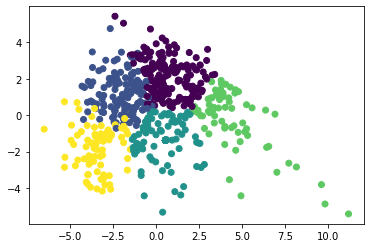

In [53]:
plt.scatter(proj[:,0], proj[:,1], c=Z)
# plt.scatter(proj[~use,0], proj[~use,1], c='k')

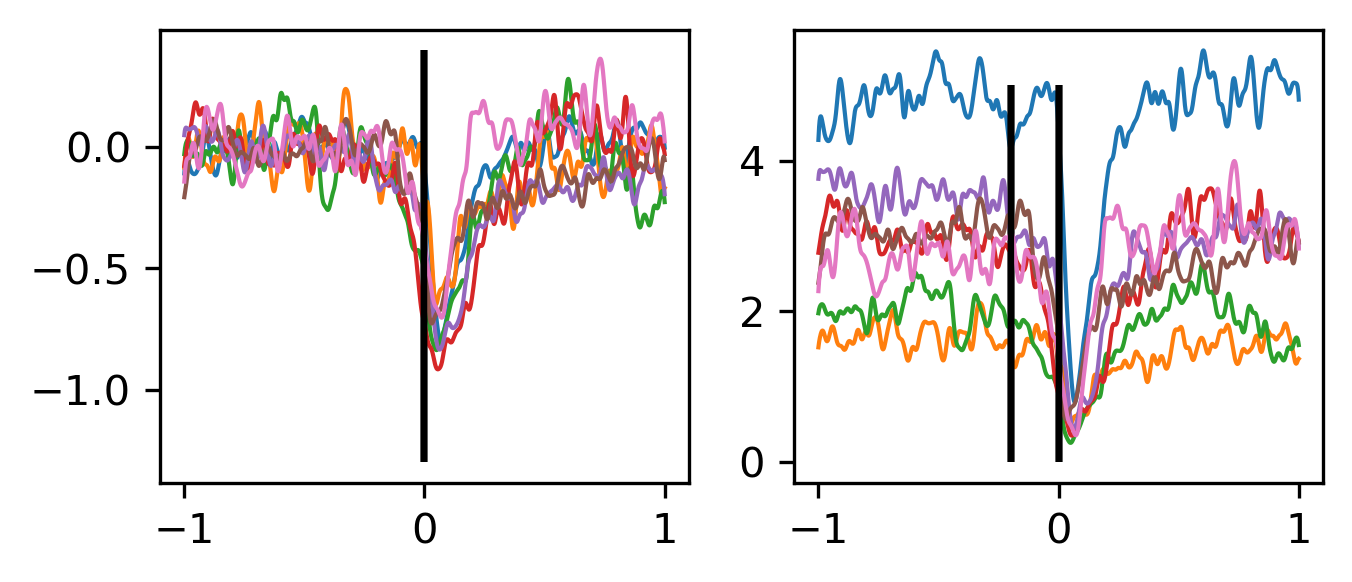

In [54]:
fig, [ax0,ax1] = plt.subplots(1,2,figsize=(5,2), dpi=300)
for ind in np.argwhere(use==False).flatten():
    ax0.plot(psth_bins, flatten_series(data['pref_gazeshift_psth'].copy())[ind,:], linewidth=1)
    ax1.plot(psth_bins, flatten_series(data['pref_gazeshift_psth_raw'].copy())[ind,:], linewidth=1)
    ax0.vlines(0,-1.3,.4,'k'); ax1.vlines(0,0,5,'k')
    ax1.vlines(-0.2,0,5,'k')

In [ ]:
plt.plot(np.cumsum(explvar))
plt.vlines(keep_pcas, np.min(np.cumsum(explvar)), 1, 'k')

### Add to the df

In [ ]:
data['gazecluster_ind'] = -1
for i, ind in enumerate(data.index.values): # [data['gazeshift_responsive']==True]
    if i in list(i2label.keys()):
        data.at[ind, 'gazecluster_ind'] = i2label[i]

In [ ]:
plt.subplots(2,3,figsize=(10,8))
for n, name in enumerate(range(-1,5)):
    plt.subplot(2,3,n+1)
    plotvals = data['pref_gazeshift_psth'][data['gazecluster_ind']==name] # pref_gazeshift_psth
    if len(plotvals.index.values)==0:
        continue
    cluster = flatten_series(plotvals)
    for i in range(np.size(cluster,0)):
        plt.plot(psth_bins, cluster[i,:], alpha=0.5)
    plt.plot(psth_bins, np.median(cluster,0), 'k-', linewidth=3)
    plt.title('{} (N={})'.format(name, len(plotvals)))
    plt.xlim([-0.3,0.3])
    plt.ylim([-1.5,1])
plt.tight_layout()

In [ ]:
plt.figure(figsize=(3,4))
plt.plot(psth_bins, np.median(flatten_series(data['pref_gazeshift_psth']),0))
plt.ylim([-1.5,1])
plt.xlim([-.3,.3])

### For ltdk data

In [ ]:
keep_pcas = 4

with open('/home/niell_lab/Desktop/dEye_PSTH_km_model1A1.pickle', 'rb') as f:
    km = pickle.load(f)
with open('/home/niell_lab/Desktop/dEye_PSTH_pca_model1A1.pickle', 'rb') as f:
    pca = pickle.load(f)

proj = pca.transform(pca_input)

use = zscore(proj[:,0])<3
gproj = proj[use,:keep_pcas]

Z = km.predict(gproj)

i2label = dict(zip(np.where(use)[0], Z))

In [ ]:
data['gazecluster_ind'] = -1
for i, ind in enumerate(data.index.values): # [data['gazeshift_responsive']==True]
    if i in list(i2label.keys()):
        data.at[ind, 'gazecluster_ind'] = i2label[i]

In [ ]:
plt.subplots(2,3,figsize=(10,8))
for n, name in enumerate(range(0,5)):
    plt.subplot(2,3,n+1)
    plotvals = data['pref_gazeshift_psth'][data['gazeshift_responsive']][data['gazecluster_ind']==name] # pref_gazeshift_psth
    if len(plotvals.index.values)==0:
        continue
    cluster = flatten_series(plotvals)
    for i in range(np.size(cluster,0)):
        plt.plot(psth_bins, cluster[i,:], alpha=0.5)
    plt.plot(psth_bins, np.median(cluster,0), 'k-', linewidth=3)
    plt.title('{} (N={})'.format(name, len(plotvals)))
    plt.xlim([-0.3,0.3])
    plt.ylim([-1.5,1])
plt.tight_layout()

## gratings

In [ ]:
for ind, row in data.iterrows():
    sec = row['Gt_eyeT'][-1].astype(float) - row['Gt_eyeT'][0].astype(float)
    sp = len(row['Gt_spikeT'])
    data.at[ind, 'Gt_fr'] = sp/sec
    
    data.at[ind, 'raw_mod_for_Gt'] = gt_modind(row['Gt_grating_psth'])
    
    data.at[ind, 'norm_mod_for_Gt'] = gt_modind(row['norm_gratings_psth'])
    
    # psth = row['Gt_grating_psth']
    # baseline = np.median(psth[1:5].copy())
    # peak = np.median(psth[5:14].copy())
    # data.at[ind, 'raw_mod_for_Gt'] = peak - baseline
    
data['Gt_responsive'] = False
for ind, row in data.iterrows():
    if (row['raw_mod_for_Gt']>1) and (row['norm_mod_for_Gt']>0.1):
        data.at[ind, 'Gt_responsive'] = True

print(data['Gt_responsive'].sum())
print(data['Gt_responsive'].sum()/len(data.index.values))

### a few visualizations

In [ ]:
from scipy import stats
def running_median(panel, x, y, n_bins=7):
    bins = np.linspace(np.min(x), np.max(x), n_bins)
    bin_means, bin_edges, bin_number = stats.binned_statistic(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)], statistic=np.median, bins=bins)
    bin_std, _, _ = stats.binned_statistic(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)], statistic=np.nanstd, bins=bins)
    hist, _ = np.histogram(x[~np.isnan(x) & ~np.isnan(y)], bins=bins)
    tuning_err = bin_std / np.sqrt(hist)
    panel.plot(bin_edges[:-1] + (np.median(np.diff(bins))/2), bin_means, '-', color='k')
    panel.fill_between(bin_edges[:-1] + (np.median(np.diff(bins))/2), bin_means-tuning_err, bin_means+tuning_err, color='k', alpha=0.2)

In [ ]:
plotdata = data[data['gazeshift_responsive']][data['Gt_responsive']].copy()

fig, ax = plt.subplots(1,1, dpi=200, figsize=(3,2))
cmaps = [cat_cmap['early'],cat_cmap['late'],cat_cmap['biphasic'],cat_cmap['negative']]
for ki, k in enumerate([0,1,4,3]):
    
    sf_prefs = plotdata['sf_pref_cpd'][~pd.isnull(plotdata['sf_pref_cpd'])][~pd.isnull(plotdata['FmLt_gazeshift_peakT'])][plotdata['gazecluster_ind']==k].copy().to_numpy()
    peak_times = plotdata['FmLt_gazeshift_peakT'][~pd.isnull(plotdata['sf_pref_cpd'])][~pd.isnull(plotdata['FmLt_gazeshift_peakT'])][plotdata['gazecluster_ind']==k].copy().to_numpy()
    
    ax.scatter(peak_times, sf_prefs, color=cmaps[ki], s=3)
    
sf_prefs = plotdata['sf_pref_cpd'][plotdata['gazecluster_ind']!=2][~pd.isnull(plotdata['sf_pref_cpd'])][~pd.isnull(plotdata['FmLt_gazeshift_peakT'])].copy().to_numpy()
peak_times = plotdata['FmLt_gazeshift_peakT'][plotdata['gazecluster_ind']!=2][~pd.isnull(plotdata['sf_pref_cpd'])][~pd.isnull(plotdata['FmLt_gazeshift_peakT'])].copy().to_numpy()
    
running_median(ax, peak_times, sf_prefs, n_bins=7)

# all_peakT = []
# for i,x in enumerate(plotdata['sf_pref_cpd'][plotdata['gazecluster_ind']!=3]):
#     all_peakT.append(psth_bins[np.argmax(x[startwin:endwin])+startwin])
# all_peakT = np.array(all_peakT)
    
# sf_prefs = plotdata['sf_pref_cpd'][plotdata['gazecluster_ind']!=1].copy().to_numpy()

ax.set_ylabel('spatial freq (cpd)')
ax.set_xlabel('peak latency (sec)')

# ax.set_xlim([0,.175])
ax.set_xticks(np.linspace(0, 0.170, 7), labels=np.linspace(0, 170, 7).astype(int))

ax.set_ylim([0,0.2])

ax.vlines(0.033,0,.32,'k',linestyle='dashed', linewidth=1)
# plt.hlines(.33,0.015, .2,'k',linestyle='dashed', linewidth=1)


In [ ]:
startwin = 1015
endwin = 1200
print(endwin-startwin)
plotdata = data[data['use']].copy()#[data1['use']].copy() #[data1['session']!='032022_J599LT_control_Rig2'].copy() # 
fig, ax = plt.subplots(1,1, dpi=300, figsize=(3,2))
cmaps = [cat_cmap['early'],cat_cmap['late'],cat_cmap['biphasic'],cat_cmap['negative']]
for ki, k in enumerate([0,2,4,1]):
    sf_prefs = plotdata['gazeshift_dirselind'][plotdata['gazecluster_ind']==k].copy().to_numpy()
    for i,x in enumerate(plotdata['pref_gazeshift_psth'][plotdata['gazecluster_ind']==k]): # gazecluster_ind
        peakT = psth_bins[np.argmax(x[startwin:endwin])+startwin]

        ax.plot(peakT, sf_prefs[i], '.', color=cmaps[ki], markersize=3)
all_peakT = []
for i,x in enumerate(plotdata['pref_gazeshift_psth'][plotdata['gazecluster_ind']!=3]):
    all_peakT.append(psth_bins[np.argmax(x[startwin:endwin])+startwin])
all_peakT = np.array(all_peakT)
    
sf_prefs = plotdata['gazeshift_dirselind'][plotdata['gazecluster_ind']!=3].copy().to_numpy()

all_peakT = all_peakT[~np.isnan(sf_prefs)]
sf_prefs = sf_prefs[~np.isnan(sf_prefs)]

running_median(ax, all_peakT, sf_prefs, n_bins=14)
# ax.set_ylim([0,0.2])
ax.set_ylabel('gaze direction selectivity')
ax.set_xlabel('peak latency (sec)')
plt.vlines(0.035,0,.8,'k',linestyle='dashed', linewidth=1)
plt.hlines(.33,0.015,.2,'k',linestyle='dashed', linewidth=1)


# dark modulation

In [ ]:
for ind, row in data.iterrows():
    norm_psth = row['pref_dark_gazeshift_psth'].copy().astype(float)
    data.at[ind, 'norm_dark_modulation'] = psth_modind(norm_psth)
    
    raw_psth = row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(row['pref_gazeshift_direction'])].copy().astype(float)
    data.at[ind, 'dark_modulation'] = psth_modind(raw_psth)

In [ ]:
cmaps = [cat_cmap['early'],cat_cmap['late'],cat_cmap['biphasic'],cat_cmap['negative']]

plotvals = data[data['gazeshift_responsive']][data['gazecluster_ind']!=4].copy()

for ind in plotvals.index.values:
    plt.plot(plotvals.loc[ind,'FmDk_gazeshift_peakT'], plotvals.loc[ind,'gazeshift_dirselind'], '.', color=cmaps[plotvals.loc[ind,'gazecluster_ind']])
plt.xlabel('peakT'); plt.ylabel('direction selectivity')
plt.vlines(.033, 0, 1, 'k')
plt.hlines(0, 0.010, .170, 'k')

In [ ]:
movement_inds = data[data['movcluster1']=='movement'].index.values

In [ ]:
ind = 292
row = data.loc[ind].copy()

fig, axs = plt.subplots(2,2,figsize=(3,3),dpi=200)

light_pref = row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(row['pref_gazeshift_direction'])]
light_nonpref = row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(row['nonpref_gazeshift_direction'])]

dark_pref = row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(row['pref_gazeshift_direction'])]
dark_nonpref = row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(row['nonpref_gazeshift_direction'])]

axs[0,0].plot(psth_bins, light_pref, 'k')
axs[0,1].plot(psth_bins, light_nonpref, 'k')
axs[1,0].plot(psth_bins, dark_pref, 'k')
axs[1,1].plot(psth_bins, dark_nonpref, 'k')

axs[0,0].set_title('light pref')
axs[0,1].set_title('light non-pref')
axs[1,0].set_title('dark pref')
axs[1,1].set_title('dark non-pref')

for i in range(2):
    for j in range(2):
        axs[i,j].set_xlim([-0.3,0.3])
        axs[i,j].set_ylim([0, np.max([light_pref, light_nonpref, dark_pref, dark_nonpref])*1.1])

fig.tight_layout()

In [ ]:
cmaps = [cat_cmap['early'],cat_cmap['late'],cat_cmap['biphasic'],cat_cmap['negative']]

data['dark_responsive'] = False

for ki, k in enumerate([0,4,1,2]):
    
    plotvals = data[data['gazeshift_responsive']][data['gazecluster_ind']==k].copy()

    fig, [[ax0,ax1,ax2,ax3],[ax4,ax5,ax6,ax7]] = plt.subplots(2,4,figsize=(10,5), dpi=300)

    for ind in plotvals.index.values:
        row = plotvals.loc[ind].copy()
        
        fmt='.'; sz=2.5
        
        if (row['dark_modulation']>1) and (row['norm_dark_modulation']>0.1) and (row['FmDk_gazeshift_peakT']<=0.035): # (row['gazeshift_dirselind']>=.33) and
            data.at[ind, 'dark_responsive'] = True
            ax0.annotate(str(ind), xy=[row['dark_modulation'], row['norm_dark_modulation']], fontsize=6)
            ax1.annotate(str(ind), xy=[row['dark_modulation'], row['FmDk_gazeshift_peakT']], fontsize=6)
            ax2.annotate(str(ind), xy=[row['dark_modulation'], row['gazeshift_dirselind']], fontsize=6)
            
            ax3.annotate(str(ind), xy=[row['norm_dark_modulation'], row['FmDk_gazeshift_peakT']], fontsize=6)
            ax4.annotate(str(ind), xy=[row['norm_dark_modulation'], row['gazeshift_dirselind']], fontsize=6)
            
            ax5.annotate(str(ind), xy=[row['FmDk_gazeshift_peakT'], row['gazeshift_dirselind']], fontsize=6)
            
            ax6.plot(psth_bins, row['pref_dark_gazeshift_psth'], alpha=0.5)
            
            c='g'
            
        else:
            c=cmaps[ki]
            
        ax0.plot(row['dark_modulation'], row['norm_dark_modulation'],
                fmt, color=c, markersize=sz)
        ax1.plot(row['dark_modulation'], row['FmDk_gazeshift_peakT'],
                fmt, color=c, markersize=sz)
        ax2.plot(row['dark_modulation'], row['gazeshift_dirselind'],
                fmt, color=c, markersize=sz)
        ax3.plot(row['norm_dark_modulation'], row['FmDk_gazeshift_peakT'],
                fmt, color=c, markersize=sz)
        ax4.plot(row['norm_dark_modulation'], row['gazeshift_dirselind'],
                fmt, color=c, markersize=sz)
        ax5.plot(row['FmDk_gazeshift_peakT'], row['gazeshift_dirselind'],
                fmt, color=c, markersize=sz)
        
        
            

    ax0.set_xlabel('modulation (sp/sec)'); ax0.set_ylabel('norm. modulation')
    
    ax1.set_xlabel('modulation (sp/sec)'); ax1.set_ylabel('latency')
    
    ax2.set_xlabel('modulation (sp/sec)'); ax2.set_ylabel('DSI')
    
    ax3.set_xlabel('norm. modulation'); ax3.set_ylabel('latency')
    
    ax4.set_xlabel('norm. modulation'); ax4.set_ylabel('DSI')
    
    ax5.set_xlabel('latency'); ax5.set_ylabel('DSI')

    # (row['gazeshift_dirselind']>.33)
    # [plotvals['gazeshift_dirselind']>.33]
    
    kname = ['early','late','biphasic','negative'][ki]
    
    use_for_med = plotvals['pref_dark_gazeshift_psth'][plotvals['dark_modulation']>1][plotvals['norm_dark_modulation']>0.1][data['FmDk_gazeshift_peakT']<=0.035]#[plotvals['gazeshift_dirselind']>=.33]
    if len(use_for_med.index.values)>1:
        all_psth = flatten_series(use_for_med)
        ax6.plot(psth_bins, np.median(all_psth,0), 'k')
    ax6.set_title('dark pref. gaze shift')

    n_dark_resp = len(use_for_med.index.values)
    ax6.set_xlim([-.3,.3])
    
    ax0.set_title('{} n={}/{}'.format(kname, n_dark_resp, len(plotvals.index.values)))
    
    ax7.axis('off')
    
    fig.tight_layout()

    fig_label = 'modFr_lowLatency'
    
    fig.savefig('/home/niell_lab/Desktop/{}_{}_.png'.format(kname, fig_label))
    
# ax; ax.set_zlabel('')
# ax.set_xlim([0,17])
# ax.view_init(45, 80)

In [ ]:
plotvals = data['pref_dark_gazeshift_psth'][data['norm_dark_modulation']>0.1][data['dark_modulation']>1].copy()

fig, [ax0, ax1] = plt.subplots(2,1,figsize=(3,4), dpi=300)

ax0.plot(psth_bins, np.median(flatten_series(plotvals[plotvals['gazecluster_ind']!=3]),0), label='dark mod')

ax1.plot(psth_bins, np.median(flatten_series(plotvals[plotvals['gazecluster_ind']!=3][plotvals['gazeshift_dirselind']>.33]),0), label='dark mod & 2:1 DSI')


In [ ]:
for ind in plotvals[plotvals['norm_dark_modulation']>0.1][plotvals['dark_modulation']>0.1].index.values:
    plt.plot(psth_bins, plotvals.loc[ind, 'pref_gazeshift_psth'])
plt.xlim([-.3,.4])

In [ ]:
for x in plotvals['pref_gazeshift_psth'][data['gazeshift_dirselind']>.6]:
    plt.plot(psth_bins, x)
plt.xlim([-.3,.4])
plt.vlines(0, 0, 1, 'k')

### Name clusters

In [ ]:
np.min(np.median(flatten_series(data['pref_gazeshift_psth'][data['gazecluster_ind']==0]), axis=0))

In [ ]:
np.min(np.median(flatten_series(data['pref_gazeshift_psth'][data['gazecluster_ind']==2]), axis=0))

In [ ]:
for k in range(5):
    med_response = np.median(flatten_series(data['pref_gazeshift_psth'][data['gazecluster_ind']==k]), axis=0)
    plt.plot(psth_bins, med_response, label=k)
plt.xlim(-0.2,0.4)
plt.vlines(.07,-.5,.5 ,'k')
plt.legend()

In [ ]:
def label_movcluster(psth, el_bound=0.08):
    """
    PSTH should be the neural response to eye movements
    between -0.0625 and 0.3125 sec, where 0 is the moment
    of the eye movement.
    """

    # find peaks and troughs in PSTH
    p, peak_props = find_peaks(psth, height=.30)
    t, trough_props = find_peaks(-psth, height=.20)

    # get the time index of the highest peaks
    if len(p) > 1:
        p = p[np.argmax(peak_props['peak_heights'])]
    if len(t) > 1:
        t = t[np.argmax(trough_props['peak_heights'])]
    if p.size == 0:
        p = np.nan
    if t.size == 0:
        t = np.nan
    if ~np.isnan(p):
        p = int(p)
    if ~np.isnan(t):
        t = int(t)

    # some filtering to choose the best position for the peak
    if ~np.isnan(p):
        has_peak = True
        peak_cent = p
    else:
        has_peak = False
        peak_cent = None
    if ~np.isnan(t):
        has_trough = True
        trough_cent = t
    else:
        has_trough = False
        trough_cent = None

    # now we decide which cluster each of these should be
    el_bound_ind = np.argmin(np.abs(psth_bins-el_bound))
    if has_peak and has_trough:
        return 'biphasic'
    elif has_trough and ~has_peak:
        return 'negative'
    elif peak_cent is not None and peak_cent <= el_bound_ind:
        return 'early'
    elif peak_cent is not None and peak_cent > el_bound_ind:
        return 'late'
    else:
        return 'unresponsive'

In [ ]:
for ind, row in data.iterrows():
    if row['gazecluster_ind'] == -1:
        data.at[ind, 'gazecluster_ind'] = 0

In [ ]:
cluster_to_cell_type = {}
for l in range(5):
    med_response = np.median(flatten_series(data['pref_gazeshift_psth'][data['gazecluster_ind']==l]), axis=0)
    cluster_to_cell_type[l] = label_movcluster(med_response)
data['gazecluster'] = 'unresponsive'
for ind, row in data.iterrows():
    if row['gazeshift_responsive']:
        data.at[ind, 'gazecluster'] = cluster_to_cell_type[row['gazecluster_ind']]
data['gazecluster'].value_counts()

# Only for HFFM

## Gratings

In [ ]:
for sf in ['low','mid','high']:
    data['norm_ori_tuning_'+sf] = data['Gt_ori_tuning_tf'].copy().astype(object)
for ind, row in data.iterrows():
    orientations = np.nanmean(np.array(row['Gt_ori_tuning_tf'], dtype=np.float),2)
    for sfnum in range(3):
        sf = ['low','mid','high'][sfnum]
        data.at[ind,'norm_ori_tuning_'+sf] = orientations[:,sfnum] - row['Gt_drift_spont']
    mean_for_sf = np.array([np.mean(data.at[ind,'norm_ori_tuning_low']), np.mean(data.at[ind,'norm_ori_tuning_mid']), np.mean(data.at[ind,'norm_ori_tuning_high'])])
    mean_for_sf[mean_for_sf<0] = 0
    data.at[ind,'sf_pref'] = ((mean_for_sf[0]*1)+(mean_for_sf[1]*2)+(mean_for_sf[2]*3))/np.sum(mean_for_sf)

data['osi_for_sf_pref'] = np.nan
data['dsi_for_sf_pref'] = np.nan
for ind, row in data.iterrows():
    if ~np.isnan(row['sf_pref']):
        best_sf_pref = int(np.round(row['sf_pref']))
        data.at[ind, 'osi_for_sf_pref'] = row[(['Gt_osi_low','Gt_osi_mid','Gt_osi_high'][best_sf_pref-1])]
        data.at[ind, 'dsi_for_sf_pref'] = row[(['Gt_dsi_low','Gt_dsi_mid','Gt_dsi_high'][best_sf_pref-1])]

data['osi_for_sf_pref'][data['osi_for_sf_pref']<0] = 0
data['dsi_for_sf_pref'][data['dsi_for_sf_pref']<0] = 0
for ind, row in data.iterrows():
    try:
        mean_for_sf = np.array([np.mean(data.at[ind,'norm_ori_tuning_low']), np.mean(data.at[ind,'norm_ori_tuning_mid']), np.mean(data.at[ind,'norm_ori_tuning_high'])])
        mean_for_sf[mean_for_sf<0] = 0
        data.at[ind, 'Gt_evoked_rate'] = np.max(mean_for_sf) - row['Gt_drift_spont']
    except:
        pass

for ind, row in data.iterrows():
    if type(row['Gt_ori_tuning_tf']) != float:
        tuning = np.nanmean(row['Gt_ori_tuning_tf'],1)
        tuning = tuning - row['Gt_drift_spont']
        tuning[tuning < 0] = 0
        mean_for_tf = np.array([np.mean(tuning[:,0]), np.mean(tuning[:,1])])
        tf_pref = ((mean_for_tf[0]*1)+(mean_for_tf[1]*2))/np.sum(mean_for_tf)
        data.at[ind, 'tf_pref'] = tf_pref

for ind, row in data.iterrows():
    tf = 2 + (6 * (row['tf_pref']-1))
    sf = 0.02 * 4 ** (row['sf_pref']-1)
    data.at[ind,'tf_pref_cps'] = tf
    data.at[ind,'sf_pref_cpd'] = sf
    data.at[ind,'grat_speed_dps'] = tf / sf

# Some light/dark calcs

In [ ]:
model_dt = 0.025
for ind, row in data.iterrows():
    modelT = np.arange(0, np.nanmax(row['FmLt_eyeT']), model_dt)
    
    # timing is off sometimes... using eyeT instead of worldT to get maximum length
    # and they can be different by a few frames
    diff = len(modelT) - len(row['FmLt_rate'])
    if diff>0: # modelT is longer
        modelT = modelT[:-diff]
    elif diff<0: # modelT is shorted
        for i in range(np.abs(diff)):
            modelT = np.append(modelT, modelT[-1]+model_dt)
    model_gz = interp1d(row['FmLt_imuT'], row['FmLt_gyro_z'], bounds_error=False)(modelT)
    model_active = np.convolve(np.abs(model_gz), np.ones(int(1/model_dt)), 'same') / len(np.ones(int(1/model_dt)))
    data.at[ind, 'FmLt_model_active'] = model_active.astype(object)
    data.at[ind, 'FmLt_modelT'] = modelT.astype(object)
    
    modelT = np.arange(0, np.nanmax(row['FmDk_eyeT']), model_dt)
    diff = len(modelT) - len(row['FmDk_rate'])
    if diff>0: # modelT is longer
        modelT = modelT[:-diff]
    elif diff<0: # modelT is shorted
        for i in range(np.abs(diff)):
            modelT = np.append(modelT, modelT[-1]+model_dt)
    model_gz = interp1d(row['FmDk_imuT'], row['FmDk_gyro_z'], bounds_error=False)(modelT)
    model_active = np.convolve(np.abs(model_gz), np.ones(int(1/model_dt)), 'same') / len(np.ones(int(1/model_dt)))
    data.at[ind, 'FmDk_model_active'] = model_active.astype(object)
    data.at[ind, 'FmDk_modelT'] = modelT.astype(object)

In [ ]:
data['FmLt_fr'] = ((data['FmLt_rate'].apply(np.sum)*0.025) / data['FmLt_eyeT'].apply(np.nanmax)).to_numpy()
data['FmDk_fr'] = ((data['FmDk_rate'].apply(np.sum)*0.025) / data['FmDk_eyeT'].apply(np.nanmax)).to_numpy()

In [ ]:
FmLt_fr = np.zeros([len(data.index.values)])
FmDk_fr = np.zeros([len(data.index.values)])
for ind, row in data.iterrows():
    data.at[ind,'FmLt_active_fr'] = (np.sum(row['FmLt_rate'][row['FmLt_model_active']>40])) / np.size(row['FmLt_modelT'][row['FmLt_model_active']>40])
    data.at[ind,'FmLt_inactive_fr'] = (np.sum(row['FmLt_rate'][row['FmLt_model_active']<40])) / np.size(row['FmLt_modelT'][row['FmLt_model_active']<40])
    data.at[ind,'FmDk_active_fr'] = (np.sum(row['FmDk_rate'][row['FmDk_model_active']>40])) / np.size(row['FmDk_modelT'][row['FmDk_model_active']>40])
    data.at[ind,'FmDk_inactive_fr'] = (np.sum(row['FmDk_rate'][row['FmDk_model_active']<40])) / np.size(row['FmDk_modelT'][row['FmDk_model_active']<40])

## light/dark correlation

In [ ]:
for ind, row in data[['pref_dark_gazeshift_psth','pref_gazeshift_psth']].iterrows():
    r = np.corrcoef(row['pref_gazeshift_psth'].astype(float)[1000:1250], row['pref_dark_gazeshift_psth'].astype(float)[1000:1250])
    data.at[ind, 'gaze_ltdk_maxcc'] = r[0,1]

# Head-fixed vs. gaze correlation

In [ ]:
for ind, row in data[['norm_Rc_psth','norm_Sn_psth','pref_gazeshift_psth']].iterrows():
    if (np.sum(~np.isnan(row['norm_Rc_psth'].astype(float)[1000]))>0) and (np.sum(~np.isnan(row['pref_gazeshift_psth'].astype(float)))>0):
        r = np.corrcoef(row['pref_gazeshift_psth'].astype(float)[1000:1250], row['norm_Rc_psth'].astype(float)[1000:1250])
        data.at[ind, 'gaze_rc_maxcc'] = r[0,1]
    if (np.sum(~np.isnan(row['norm_Sn_psth'].astype(float)))>0) and (np.sum(~np.isnan(row['pref_gazeshift_psth'].astype(float)))>0):
        r = np.corrcoef(row['pref_gazeshift_psth'].astype(float)[1000:1250], row['norm_Sn_psth'].astype(float)[1000:1250])
        data.at[ind, 'gaze_sn_maxcc'] = r[0,1]

# Save the dataset as a pickle

In [ ]:
data.to_pickle('/home/niell_lab/Data/freely_moving_ephys/batch_files/061522/ltdk_061522.pickle')

# Other

In [ ]:
fig1 = plt.figure(constrained_layout=True, figsize=(9,7.6), dpi=300)
fig1spec = gridspec.GridSpec(nrows=5, ncols=3, figure=fig1, wspace=1.5, hspace=1.5)

fig1Cspec = gridspec.GridSpecFromSubplotSpec(3,1,subplot_spec=fig1spec[0:2,1], wspace=0, hspace=0.01)
ax_theta = fig1.add_subplot(fig1Cspec[0,0])
ax_yaw = fig1.add_subplot(fig1Cspec[1,0])
ax_gaze = fig1.add_subplot(fig1Cspec[2,0])

fig1Dspec = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=fig1spec[0:2,2], wspace=0, hspace=0)
ax_dEyeHead = fig1.add_subplot(fig1Dspec[0,0])

fig1E2Fspec = gridspec.GridSpecFromSubplotSpec(3,3,subplot_spec=fig1spec[2:,0:2], wspace=0.15, hspace=-.05)

ax_pos_rasterG = fig1.add_subplot(fig1E2Fspec[0,0])
ax_biph_rasterG = fig1.add_subplot(fig1E2Fspec[0,1])
ax_neg_rasterG = fig1.add_subplot(fig1E2Fspec[0,2])

ax_pos_rasterC = fig1.add_subplot(fig1E2Fspec[1,0])
ax_biph_rasterC = fig1.add_subplot(fig1E2Fspec[1,1])
ax_neg_rasterC = fig1.add_subplot(fig1E2Fspec[1,2])

ax_pos_psth = fig1.add_subplot(fig1E2Fspec[2,0])
ax_biph_psth = fig1.add_subplot(fig1E2Fspec[2,1])
ax_neg_psth = fig1.add_subplot(fig1E2Fspec[2,2])

fig1Gspec = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=fig1spec[2:,2:], wspace=0.2, hspace=0.1)
ax_ex_gaze = fig1.add_subplot(fig1Gspec[0,0])
ax_ex_comp = fig1.add_subplot(fig1Gspec[1,0])

start = 2090 #2100
win = 60 # frames, not sec
ex_units = [171,112,126]
ex_units_direcprefs = ['left','left','right']

ylim_val = 36
theta_data = demo['FmLt_theta'][start:start+win]
theta_data = theta_data - np.nanmean(theta_data)
ax_theta.plot(theta_data, 'k-', linewidth=2, scaley=10)
ax_theta.set_xlim([0,60]); ax_theta.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_theta.set_ylabel('theta (deg)')
ax_theta.set_ylim([-ylim_val,ylim_val])
ax_theta.axes.get_xaxis().set_visible(False)
ax_theta.axes.spines.bottom.set_visible(False)

pYaw = np.nancumsum(demo['FmLt_dHead'][start:start+win]*0.016)
pYaw = pYaw - np.nanmean(pYaw)
ax_yaw.plot(pYaw, 'k-', linewidth=2)
ax_yaw.set_xlim([0,60])
ax_yaw.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_yaw.set_ylabel('yaw (deg)')
ax_yaw.axes.get_xaxis().set_visible(False)
ax_yaw.axes.spines.bottom.set_visible(False)
ax_yaw.set_ylim([-ylim_val,ylim_val])

ax_gaze.plot(pYaw + theta_data, 'k-', linewidth=2)
ax_gaze.set_xlim([0,60])
ax_gaze.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1000,5).astype(int))
ax_gaze.set_ylabel('gaze (deg)')
ax_gaze.set_ylim([-ylim_val,ylim_val])
ax_gaze.set_xlabel('time (msec)')

for i in plotinds:
    dGaze_i = np.abs(dHead_data[i]+dEye_data[i])
    if eyeT[i] in gazemovs:
        c = colors['gaze']
    elif eyeT[i] in comp:
        c = colors['comp']
    elif (np.abs(dHead_data[i])<60) or ((dGaze_i<240) and (dGaze_i>120)):
        c = 'dimgray'
    else:
        continue
    ax_dEyeHead.plot(dHead_data[i], dEye_data[i], '.', color=c, markersize=2)

ax_dEyeHead.set_aspect('equal','box')
ax_dEyeHead.set_xlim([-600,600])
ax_dEyeHead.set_ylim([-600,600])
ax_dEyeHead.set_xlabel('head velocity (deg/sec)')
ax_dEyeHead.set_ylabel('eye velocity (deg/sec)')
ax_dEyeHead.plot([-500,500],[500,-500], linestyle='dashed', color='k', linewidth=1)
# ax_dEyeHead.annotate('left', xy=[350,500], color='k')
# ax_dEyeHead.annotate('right', xy=[-550,-500], color='k')
# ax_dEyeHead.annotate('gaze shift', xy=[-620,470], color=colors['gaze'])
# ax_dEyeHead.annotate('compensated', xy=[-620,550], color=colors['comp'])
ax_dEyeHead.set_xticks(np.linspace(-600,600,5))
ax_dEyeHead.set_yticks(np.linspace(-600,600,5))

num_movements = 500
raster_panelsG = [ax_pos_rasterG, ax_biph_rasterG, ax_neg_rasterG]
raster_panelsC = [ax_pos_rasterC, ax_biph_rasterC, ax_neg_rasterC]
sdf_panels = [ax_pos_psth, ax_biph_psth, ax_neg_psth]
for i, u in enumerate(ex_units):
    row = hffm.iloc[u]
    rasterG = raster_panelsG[i]
    rasterC = raster_panelsC[i]
    sdf_panel = sdf_panels[i]
    LR = ex_units_direcprefs[i]
    
    rasterG.set_title(['positive','biphasic','negative'][i])

    gazeshifts = row['FmLt_gazeshift_{}_saccTimes_dHead'.format(LR)].copy()
    compmovs = np.hstack([row['FmLt_comp_left_saccTimes_dHead'], row['FmLt_comp_right_saccTimes_dHead']])
    
    plot_gs = np.random.choice(gazeshifts, size=num_movements, replace=False)
    plot_cp = np.random.choice(compmovs, size=num_movements, replace=False)

    for n, s in enumerate(plot_gs):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        rasterG.plot(sp, np.ones(sp.size)*n, '|', color=colors['gaze'], markersize=0.25)

    for n, s in enumerate(plot_cp):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        rasterC.plot(sp, np.ones(sp.size)*n, '|', color=colors['comp'], markersize=0.25)
    
    rasterG.set_ylim([num_movements, 0]); rasterC.set_ylim([num_movements,0])
    rasterG.vlines(0, 0, num_movements, color='k', linewidth=1, linestyle='dashed')
    rasterC.vlines(0, 0, num_movements, color='k', linewidth=1, linestyle='dashed')
    if i == 0:
        rasterG.set_ylabel('gaze shifts'); rasterC.set_ylabel('compensatory')
        rasterG.set_yticks(np.linspace(0, 500, 3))
        rasterC.set_yticks(np.linspace(0, 500, 3))
    else:
        rasterG.set_yticks(np.linspace(0, 500, 3),labels=[])
        rasterC.set_yticks(np.linspace(0, 500, 3),labels=[])
    rasterG.set_xticks([]); rasterC.set_xticks([])
    rasterG.set_xlim([-.5,.5]); rasterC.set_xlim([-.5,.5])
    rasterG.axes.spines.bottom.set_visible(False); rasterC.axes.spines.bottom.set_visible(False)
    
    sdf_panel.plot(psth_bins, row['FmLt_comp_{}_saccPSTH_dHead'.format(LR)], color=colors['comp'])
    sdf_panel.plot(psth_bins, row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)], color=colors['gaze'])
    max_fr = np.nanmax(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)])*1.1
    sdf_panel.set_ylim([0,max_fr])
    sdf_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    sdf_panel.set_xlim([-.5,.5])
    if i == 0:
        sdf_panel.set_ylabel('spike rate (sp/sec)')
    sdf_panel.set_xlabel('time (msec)')
    sdf_panel.vlines(0, 0, max_fr, color='k', linewidth=1, linestyle='dashed')

possible_inds = hffm['pref_comp_psth'][hffm['fr']>2].index.values
np.random.seed(1)
example_inds = np.sort(np.random.choice(possible_inds, size=50, replace=False))

for ind in example_inds:
    ax_ex_gaze.plot(psth_bins, hffm.loc[ind,'pref_gazeshift_psth'].astype(float), linewidth=1, alpha=0.3)
    ax_ex_comp.plot(psth_bins, hffm.loc[ind,'pref_comp_psth'].astype(float), linewidth=1, alpha=0.3)
ax_ex_gaze.set_xlim([-.5,.5])
ax_ex_gaze.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
ax_ex_comp.set_xlim([-.5,.5])
ax_ex_comp.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
ax_ex_gaze.set_ylim([-.7,1])
ax_ex_comp.set_ylim([-.7,1])
ax_ex_gaze.set_ylabel('norm. spike rate')
ax_ex_comp.set_ylabel('norm. spike rate')
ax_ex_comp.set_xlabel('time (msec)')
ax_ex_gaze.set_xlabel('time (msec)')

all_comp = flatten_series(hffm['pref_comp_psth'][hffm['gazecluster']!='unresponsive'][hffm['gazeshift_responsive']])
all_gaze = flatten_series(hffm['pref_gazeshift_psth'][hffm['gazecluster']!='unresponsive'][hffm['gazeshift_responsive']])

comp_mean = np.nanmedian(all_comp,0)
comp_std = np.std(all_comp,0) / np.sqrt(np.size(all_comp))

gaze_mean = np.nanmedian(all_gaze,0)
gaze_std = np.std(all_gaze,0) / np.sqrt(np.size(all_gaze))
ax_ex_comp.set_title('compensatory')
ax_ex_gaze.set_title('gaze-shifting')
ax_ex_comp.plot(psth_bins, comp_mean, color=colors['comp'], linewidth=3)
ax_ex_gaze.plot(psth_bins, gaze_mean, color=colors['gaze'], linewidth=3)

